In [295]:
# http://www.cs.umd.edu/class/spring2023/cmsc320-0101/files/tutorial.pdf

Introduction:
Communication during warfare has always been of the utmost importance, especially in military intelligence and counter-intelligence. As warfare has become more complex, so too has the information that must be passed around. With this increase in complexity, data processing and statistical techniques have become vital to make sense of the incoming data in order to use resources more efficiently and prevent unnessesary losses, not only of equipment but also of life.

In [296]:
import requests
from numpy import NaN
import pandas as pd
import numpy as np
import re
import datetime
from urllib.request import urlopen
from bs4 import BeautifulSoup
import math
import matplotlib.pyplot as plt

Data Collection

This tutorial is using data collected on the current war in Ukraine, that has been made publicly available at [link]

Data Curation, Parsing, and Management

In [297]:
headers = { 'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/110.0.0.0 Safari/537.36','From': 'pleaseletmein@gmail.com'}

#r = requests.get('https://www.spaceweatherlive.com/en/solar-activity/top-50-solar-flares.html', headers=headers)

In [298]:
# Russian equipment lost per day since start of war split into category
# https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war (info about categories and datasource)
df_RU_equipment = pd.read_csv("data/russia_losses_equipment.csv")
# Convert the date to standardized datetime format
df_RU_equipment['date'] = pd.to_datetime(df_RU_equipment['date'])
# Reorder the columns for ease of viewing
df_RU_equipment = df_RU_equipment.set_index(['date', 'day', 'greatest losses direction'])
# df_RU_equipment = df_RU_equipment.drop('greatest losses direction', axis=1)
# set missing entries to NaN
df_RU_equipment = df_RU_equipment.diff().fillna(df_RU_equipment).fillna(0).astype(int).reset_index()
# Display part of the data
df_RU_equipment.tail(10)

,date,day,greatest losses direction,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
399,2023-03-31,401,NaN,0,0,5,3,4,0,0,0,9,0,0,3,0,3,0
400,2023-04-01,402,NaN,0,0,1,4,8,1,0,0,0,0,1,2,0,7,0
401,2023-04-02,403,NaN,0,0,2,5,4,0,0,0,1,0,0,0,0,9,0
402,2023-04-03,404,NaN,0,0,1,7,7,0,0,0,13,0,1,2,0,16,0
403,2023-04-04,405,NaN,0,0,8,6,3,1,0,0,15,0,0,0,0,9,0
404,2023-04-05,406,NaN,0,0,2,6,10,4,0,0,6,0,0,1,0,11,0
405,2023-04-06,407,NaN,0,1,2,8,7,0,0,0,4,0,1,3,0,1,0
406,2023-04-07,408,NaN,0,0,2,3,8,1,0,0,4,0,0,2,0,13,0
407,2023-04-08,409,NaN,1,0,3,4,5,0,0,0,7,0,1,0,0,12,0
408,2023-04-09,410,NaN,0,0,0,4,13,0,0,0,14,0,0,5,0,3,0


In [299]:
# Russian personnel lost per day
# Prisoners column stopped being updated since 2022-04-28
# https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war (info about categories and datasource)
df_RU_personnel = pd.read_csv("data/russia_losses_personnel.csv")
df_RU_personnel['date'] = pd.to_datetime(df_RU_personnel['date'])
df_RU_personnel = df_RU_personnel.set_index(['date', 'day', 'personnel*'])
df_RU_personnel = df_RU_personnel.diff().fillna(df_RU_personnel).fillna(0).astype(int).reset_index()
df_RU_personnel.tail(10)

,date,day,personnel*,personnel,POW
399,2023-03-31,401,about,460,0
400,2023-04-01,402,about,630,0
401,2023-04-02,403,about,560,0
402,2023-04-03,404,about,610,0
403,2023-04-04,405,about,530,0
404,2023-04-05,406,about,550,0
405,2023-04-06,407,about,390,0
406,2023-04-07,408,about,480,0
407,2023-04-08,409,about,570,0
408,2023-04-09,410,about,470,0


In [300]:
# total breakdown of visually confirmed Ukrainian losses (have image of destruction) during war
# https://www.kaggle.com/datasets/5481b37f75c2bc8587e527d6e4d6fd7a81ac46e329e1946c8f85210cbe662eb5  (info about categories and datasource)
df_UA_total = pd.read_csv("data/losses_ukraine.csv")
df_UA_total.tail(5)

,equipment,model,sub_model,manufacturer,losses_total,Unnamed: 5,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia
285,"Trucks, Vehicles and Jeeps",Peugeot P4,NaN,France,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
286,"Trucks, Vehicles and Jeeps",Unknown tanker,NaN,Ukraine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
287,"Trucks, Vehicles and Jeeps",Unknown truck,NaN,Ukraine,65,NaN,NaN,NaN,4.0,NaN,2.0,1.0,NaN,NaN,58.0,NaN,NaN,NaN
288,"Trucks, Vehicles and Jeeps",Unknown truck,with ZU-23 AA gun,Ukraine,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
289,"Trucks, Vehicles and Jeeps",Unknown vehicle,NaN,Ukraine,42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN,NaN,NaN


In [301]:
# Breakdown of visually confirmed Ukrainian losses grouped by equipment type
df_UA_total_grouped = df_UA_total.groupby(['equipment']).sum()
# Drop empty column
df_UA_total_grouped.drop(["Unnamed: 5"], axis=1, inplace=True)

# Display the grouped data
df_UA_total_grouped

/var/folders/8v/0ps355_15j1bvhs10qz0n6980000gn/T/ipykernel_86780/1251358407.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_UA_total_grouped = df_UA_total.groupby(['equipment']).sum()


,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia
equipment,,,,,,,,,,,,,
Aircraft,57,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,55.0,0.0,0.0,0.0
Anti-Aircraft Guns,4,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Armoured Fighting Vehicles,260,4.0,0.0,77.0,0.0,3.0,1.0,1.0,0.0,174.0,0.0,0.0,0.0
Armoured Personnel Carriers,223,3.0,0.0,81.0,0.0,10.0,5.0,3.0,0.0,121.0,0.0,0.0,0.0
Artillery Support Vehicles And Equipment,22,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0
Command Posts And Communications Stations,9,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0
Engineering Vehicles And Equipment,43,0.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,21.0,0.0,0.0,0.0
Helicopters,29,0.0,0.0,3.0,0.0,1.0,0.0,0.0,0.0,25.0,0.0,0.0,0.0
Infantry Fighting Vehicles,471,21.0,1.0,101.0,3.0,12.0,5.0,1.0,0.0,327.0,0.0,0.0,0.0


In [302]:
# total breakdown of visually confirmed Russian losses (have image of destruction) during war
# https://www.kaggle.com/datasets/5481b37f75c2bc8587e527d6e4d6fd7a81ac46e329e1946c8f85210cbe662eb5  (info about categories and datasource)
df_RU_total = pd.read_csv("data/losses_russia.csv")
df_RU_total.tail(5)

,equipment,model,sub_model,manufacturer,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,destroyed in a non-combat related incident,sunk
333,"Trucks, Vehicles and Jeeps",UAZ-394511 ‘Esaul’,NaN,Russia,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN,NaN
334,"Trucks, Vehicles and Jeeps",UAZ-515195 'Esaul',NaN,Russia,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
335,"Trucks, Vehicles and Jeeps",Unknown fuel tanker,NaN,Russia,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN
336,"Trucks, Vehicles and Jeeps",(Unknown) truck,NaN,Russia,262,1.0,NaN,10.0,1.0,NaN,7.0,2.0,NaN,NaN,241.0,NaN,NaN
337,"Trucks, Vehicles and Jeeps",(Unknown) vehicle,NaN,Russia,45,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,39.0,NaN,NaN


In [303]:
# Breakdown of visually confirmed Russian losses grouped by equipment type
df_RU_total_grouped = df_RU_total.groupby(['equipment']).sum()

# Display the grouped data
df_RU_total_grouped

/var/folders/8v/0ps355_15j1bvhs10qz0n6980000gn/T/ipykernel_86780/965525252.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_RU_total_grouped = df_RU_total.groupby(['equipment']).sum()


,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,captured and stripped,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,destroyed in a non-combat related incident,sunk
equipment,,,,,,,,,,,,,
Aircraft,69,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,52.0,9.0,0.0
Anti-Aircraft Guns,16,0.0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0
Armoured Fighting Vehicles,773,24.0,0.0,246.0,1.0,0.0,12.0,1.0,11.0,0.0,478.0,0.0,0.0
Armoured Personnel Carriers,296,11.0,0.0,92.0,0.0,0.0,5.0,1.0,4.0,0.0,183.0,0.0,0.0
Artillery Support Vehicles And Equipment,91,2.0,3.0,45.0,1.0,0.0,0.0,0.0,4.0,0.0,36.0,0.0,0.0
Command Posts And Communications Stations,230,2.0,0.0,81.0,1.0,0.0,0.0,1.0,8.0,0.0,137.0,0.0,0.0
Engineering Vehicles And Equipment,268,31.0,1.0,101.0,0.0,0.0,4.0,7.0,7.0,0.0,117.0,0.0,0.0
Helicopters,75,0.0,3.0,0.0,0.0,0.0,10.0,0.0,1.0,0.0,59.0,2.0,0.0
Infantry Fighting Vehicles,2002,60.0,0.0,541.0,1.0,3.0,59.0,30.0,48.0,0.0,1259.0,0.0,0.0


In [304]:
# https://www.tutorialspoint.com/how-to-check-the-data-type-in-pandas-dataframe
print(df_RU_equipment["aircraft"].dtype)

int64


In [305]:
# Create some summary statistics for Russian equipment losses
df_RU_equipment_summary = df_RU_equipment.describe()

# Drop the "day" column - summary statistics are meaningless here
df_RU_equipment_summary.drop(["day"], axis=1, inplace=True)
# Drop the "count" column - already know we have 1 entry for each day
df_RU_equipment_summary.drop(["count"], axis=0, inplace=True)

# Return and display the summary statistics
df_RU_equipment_summary

,aircraft,helicopter,tank,APC,field artillery,MRL,military auto,fuel tank,drone,naval ship,anti-aircraft warfare,special equipment,mobile SRBM system,vehicles and fuel tanks,cruise missiles
mean,0.750611,0.713936,8.889976,17.173594,6.699267,1.303178,4.158924,0.185819,5.652812,0.044010,0.689487,0.755501,0.009780,13.696822,2.227384
std,1.760516,1.890074,8.267591,29.222636,6.193373,2.127323,15.693657,3.009738,6.677204,0.238499,1.169008,1.232276,0.139685,88.772987,9.664197
min,0.000000,0.000000,0.000000,-14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000,7.000000,3.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,7.000000,12.000000,5.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000
75%,1.000000,1.000000,13.000000,22.000000,9.000000,2.000000,0.000000,0.000000,8.000000,0.000000,1.000000,1.000000,0.000000,14.000000,0.000000
max,17.000000,20.000000,80.000000,516.000000,49.000000,17.000000,179.000000,60.000000,53.000000,2.000000,8.000000,10.000000,2.000000,1796.000000,84.000000


In [306]:
# Create some summary statistics for Ukraine equipment losses
df_UA_equipment_summary = df_UA_total_grouped.describe()

# Drop the "day" column - summary statistics are meaningless here
# df_UA_equipment_summary.drop(["day"], axis=1, inplace=True)
# Drop the "count" column - already know we have 1 entry for each day
df_UA_equipment_summary.drop(["count"], axis=0, inplace=True)

# Return and display the summary statistics
df_UA_equipment_summary

,losses_total,abandoned,abandoned and destroyed,captured,captured and destroyed,damaged,damaged and abandoned,damaged and captured,damaged beyond economical repair,destroyed,scuttled to prevent capture by Russia,sunk,sunk but raised by Russia
mean,121.333333,2.041667,0.416667,34.166667,0.458333,5.625000,1.000000,1.708333,0.041667,75.625000,0.041667,0.166667,0.041667
std,158.913886,4.515473,1.839581,45.671480,1.718927,7.482225,2.226325,3.329436,0.204124,101.707942,0.204124,0.816497,0.204124
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.750000,0.000000,0.000000,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,9.500000,0.000000,0.000000,0.000000
50%,46.000000,0.000000,0.000000,11.500000,0.000000,2.000000,0.000000,0.500000,0.000000,28.000000,0.000000,0.000000,0.000000
75%,138.250000,1.500000,0.000000,40.250000,0.000000,10.500000,1.000000,1.000000,0.000000,87.250000,0.000000,0.000000,0.000000
max,513.000000,21.000000,9.000000,149.000000,8.000000,27.000000,9.000000,12.000000,1.000000,335.000000,1.000000,4.000000,1.000000


In [307]:
# Create some summary statistics for Russian personnel losses
df_RU_personnel_summary = df_RU_personnel.describe()

df_RU_personnel_summary.drop(["day"], axis=1, inplace=True)
df_RU_personnel_summary.drop(["count"], axis=0, inplace=True)

df_RU_personnel_summary

,personnel,POW
mean,435.574572,1.212714
std,322.984140,10.972838
min,0.000000,0.000000
25%,200.000000,0.000000
50%,370.000000,0.000000
75%,620.000000,0.000000
max,3160.000000,200.000000


Exploratory Data Analysis

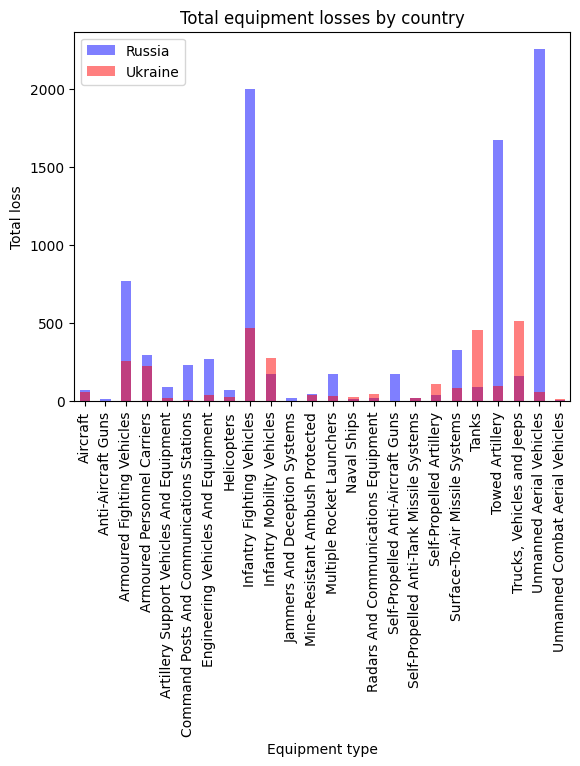

In [308]:
# TODO
    # Could do analysis on correltaions b/t Ukrainian vehical losses and Russian vehical losses, in order to see how effective the Ukrainian military is
        # Would likely want to aggregate data by vehical type
    # Could compare Russian personnel and equipment losses to find trends
# First let's compare equipment losses of each country
ax = df_RU_total_grouped['losses_total'].plot(kind='bar', color='blue', alpha=0.5, label='Russia')
df_UA_total_grouped['losses_total'].plot(kind='bar', color='red', alpha=0.5, label='Ukraine', ax=ax)
plt.title('Total equipment losses by country')
plt.xlabel('Equipment type')
plt.ylabel('Total loss')
plt.legend()
plt.show()
# alpha = 0.5 was used so we can see cases were they overlap

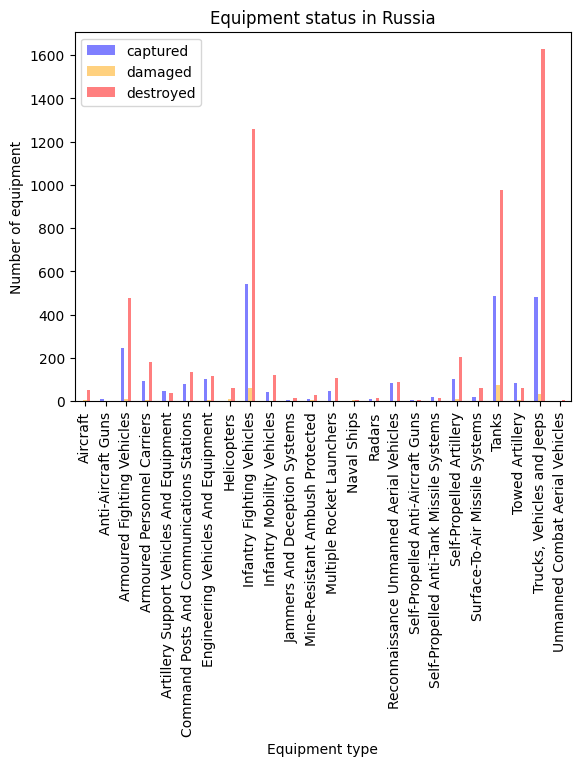

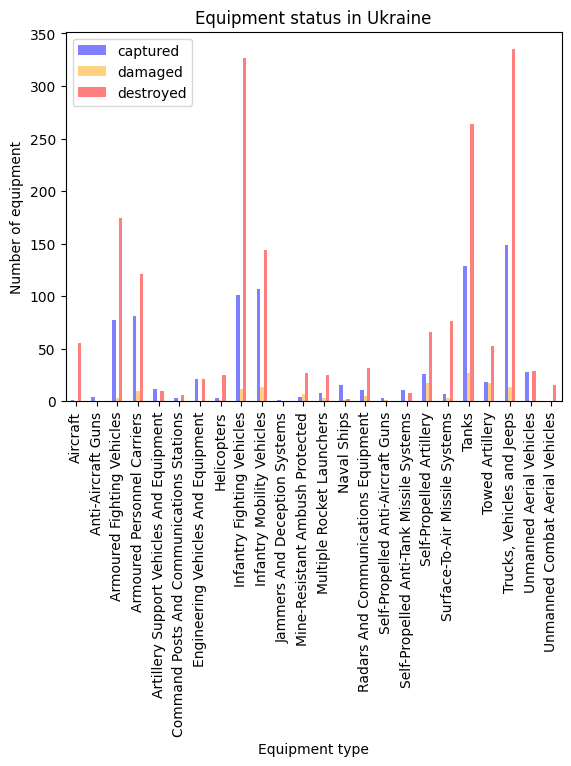

In [314]:
df_RU_total_grouped[['captured', 'damaged', 'destroyed']].plot(kind='bar', stacked=False, alpha=0.5, color=['blue', 'orange', 'red'])
plt.title('Equipment status in Russia')
plt.xlabel('Equipment type')
plt.ylabel('Number of equipment')
plt.show()

df_UA_total_grouped[['captured', 'damaged', 'destroyed']].plot(kind='bar', stacked=False, alpha=0.5, color=['blue', 'orange', 'red'])
plt.title('Equipment status in Ukraine')
plt.xlabel('Equipment type')
plt.ylabel('Number of equipment')
plt.show()

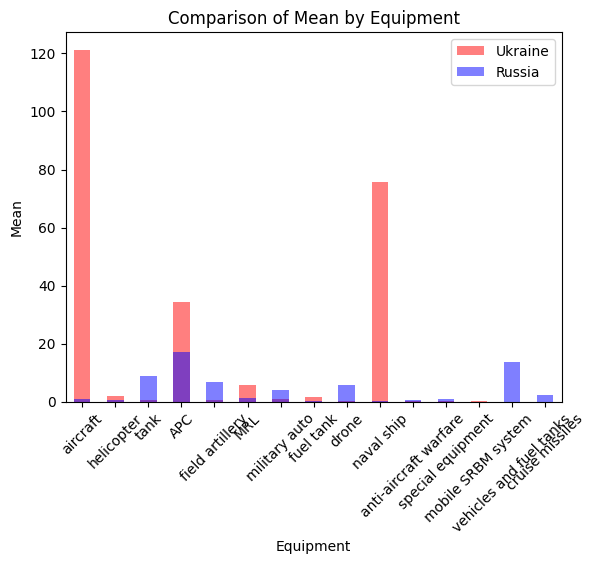

In [310]:
# A trend that we are seeing is the Russia seems to be losing much more equipments
# Than Ukraine. Let's dive a little deeper to see what is heppening

UA_means = df_UA_equipment_summary.loc['mean']
RU_means = df_RU_equipment_summary.loc['mean']
ax = UA_means.plot(kind='bar' ,color='red', alpha=0.5, label='Ukraine')
RU_means.plot(kind='bar', color='blue', alpha=0.5, label='Russia')
plt.title('Comparison of Mean by Equipment')
plt.xlabel('Equipment')
plt.ylabel('Mean')
plt.xticks(rotation=45)
plt.legend()
plt.show()


In [311]:
# as we can see, although Russia has lost more total equipments, 
# the mean of losses for Ukraine is higher. This means that in a way
# the impact of losses has been more severe for Ukraine. For example,
# If Russia had 2000 and lost 100 tanks, but Ukraine has 2 and lost both,
# Ukraine is paying a bigger price for it's losses. So we can conclude
# that both countries are paying a big price, on a global scale, 
# Russia is suffering more, but considering resources, Ukraine is.

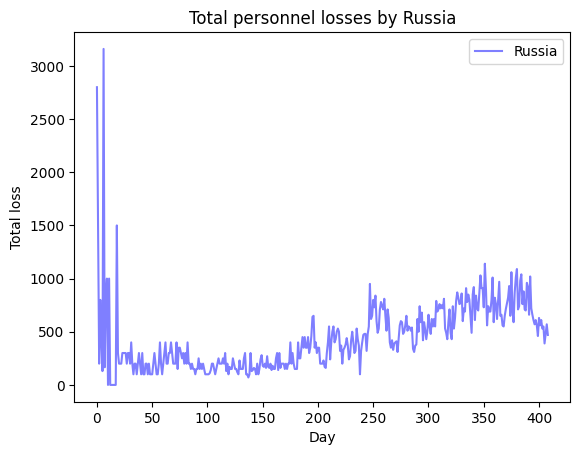

In [312]:
df_RU_personnel['personnel'].plot(kind='line', color='blue', alpha=0.5, label='Russia')

plt.title('Total personnel losses by Russia')
plt.xlabel('Day')
plt.ylabel('Total loss')
plt.legend()
plt.show()

In [ ]:
# another thing to consider is, Russia started by losing a lot of people 
# at the beginning, but they adjusted their methods and reduced the number of
# people they were losing over time, and the number remained close to the mean

Hypothesis Testing and Machine Learning

In [313]:
# TODO

Interpretation